# CPU vs GPU backend

In this notebook, we compare the use of CPU versus GPU backend in terms of computational efficiency. Note that to be able to run the notebook with GPU backend, you will need an NVIDIA GPU and having followed the installation instructions specific to GPU.

In [1]:
%matplotlib notebook

In [2]:
DEVICE = "cpu"

if DEVICE == "cpu":
    BACKEND = "numpy"
elif DEVICE == "gpu":
    BACKEND = "cupy"

In [6]:
from debiased_spatial_whittle.backend import BackendManager

BackendManager.set_backend(BACKEND)

xp = BackendManager.get_backend()


import matplotlib.pyplot as plt

from debiased_spatial_whittle.models.univariate import ExponentialModel
from debiased_spatial_whittle.grids.base import RectangularGrid
from debiased_spatial_whittle.sampling.simulation import SamplerOnRectangularGrid
from debiased_spatial_whittle.inference.periodogram import Periodogram, ExpectedPeriodogram
from debiased_spatial_whittle.inference.likelihood import Estimator, DebiasedWhittle


model = ExponentialModel(rho=5, sigma=1)


grid = RectangularGrid((512, 512))
sampler = SamplerOnRectangularGrid(model, grid)
sampler.n_sims = 50


def taper(shape):
    m, n = shape
    return np.ones((m, n))


periodogram = Periodogram()
periodogram.taper = taper
expected_periodogram = ExpectedPeriodogram(grid, periodogram)
debiased_whittle = DebiasedWhittle(periodogram, expected_periodogram)
options = dict(ftol=1e-10, gtol=1e-25)
estimator = Estimator(debiased_whittle, use_gradients=False, optim_options=options)

In [3]:
model

Name,Value,Type,Range
rho,5,ModelParameter,"(0, inf)"
sigma,1,ModelParameter,"(0, inf)"


In [9]:
from time import time

if DEVICE == "cpu":
    grid_sizes = [128, 256, 512, 1024]
elif DEVICE == "gpu":
    grid_sizes = [128, 256, 512, 1024, 2048, 4096]

results = []

for grid_size in grid_sizes:
    times = []
    grid = RectangularGrid((grid_size, grid_size))
    sampler = SamplerOnRectangularGrid(model, grid)
    sampler.n_sims = 1
    expected_periodogram = ExpectedPeriodogram(grid, periodogram)
    debiased_whittle = DebiasedWhittle(periodogram, expected_periodogram)

    for i in range(100):
        z = sampler()
        t_start = time()
        debiased_whittle(z, model)
        t_end = time()
        times.append(t_end - t_start)
    print(grid_size, xp.mean(xp.array(times)))
    results.append(times)

128 0.004572360515594482
256 0.01462679386138916
512 0.054828243255615236
1024 0.2598279595375061


In [10]:
import numpy as np

np.save(f"times{DEVICE}.npy", results)

No file found for gpu times


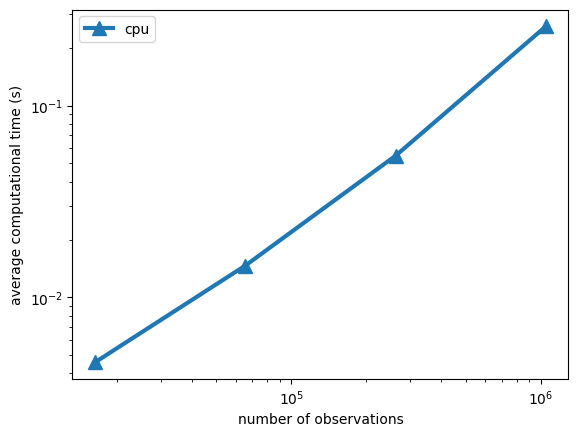

In [11]:
%matplotlib inline

plt.figure()

try:
    results_cpu = np.load("timescpu.npy")
    plt.loglog(
        np.power([128, 256, 512, 1024], 2),
        (np.mean(np.array(results_cpu), -1)),
        "-^",
        label="cpu",
        linewidth=3,
        markersize=10,
    )
except FileNotFoundError as e:
    print("No file found for cpu times")

try:
    results_gpu = np.load("timesgpu.npy")
    plt.loglog(
        np.power([128, 256, 512, 1024, 2048, 4096], 2),
        (np.mean(np.array(results_gpu), -1)),
        "-o",
        label="gpu",
        linewidth=3,
        markersize=10,
    )
except FileNotFoundError as e:
    print("No file found for gpu times")

plt.xlabel("number of observations")
plt.ylabel("average computational time (s)")
plt.legend()
plt.savefig("times.jpg", dpi=600)